<a href="https://www.kaggle.com/code/renangrothe/classifica-o-bin-ria-de-imagens-geradas-por-ia?scriptVersionId=224542753" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install exifread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, metrics, losses, optimizers
from sklearn.model_selection import train_test_split
import exifread
import cv2
import os


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

TRAINING_CSV_PATH = '/kaggle/input/detect-ai-vs-human-generated-images/train.csv'
main_dir = '/kaggle/input/ai-vs-human-generated-dataset'

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.2 MB/s eta 0:00:00
/kaggle/input
/kaggle/input/detect-ai-vs-human-generated-images
/kaggle/input/ai-vs-human-generated-dataset
/kaggle/input/ai-vs-human-generated-dataset/test_data_v2
/kaggle/input/ai-vs-human-generated-dataset/train_data


In [2]:
train_df = pd.read_csv(TRAINING_CSV_PATH, index_col='Unnamed: 0')
train_df['pair_id'] = train_df.index // 2 

print(train_df.head())

                                         file_name  label  pair_id
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1        0
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0        0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1        1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0        1
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1        2


In [3]:
# Verificar uma amostra de caminhos
sample_path = main_dir + '/' + train_df['file_name'].iloc[0]
print(f"Exemplo de caminho: {sample_path}")
print(f"Arquivo existe? {os.path.exists(sample_path)}")

# Listar alguns arquivos no diretório (para debug)
print("\nPrimeiros arquivos em train_data/:")
print(os.listdir(main_dir + '/train_data/')[:5])

Exemplo de caminho: /kaggle/input/ai-vs-human-generated-dataset/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg
Arquivo existe? True

Primeiros arquivos em train_data/:
['4139638fb5604b3e89cf871ad247203c.jpg', '0267b475538e460197576f34d657257b.jpg', '8dc94363c2ca4f688292cc83aa6751da.jpg', 'b3e8962eee154f0cabe88661224e50ff.jpg', '7eb7c1a51ecb496ab6b1eedfd578cfaa.jpg']


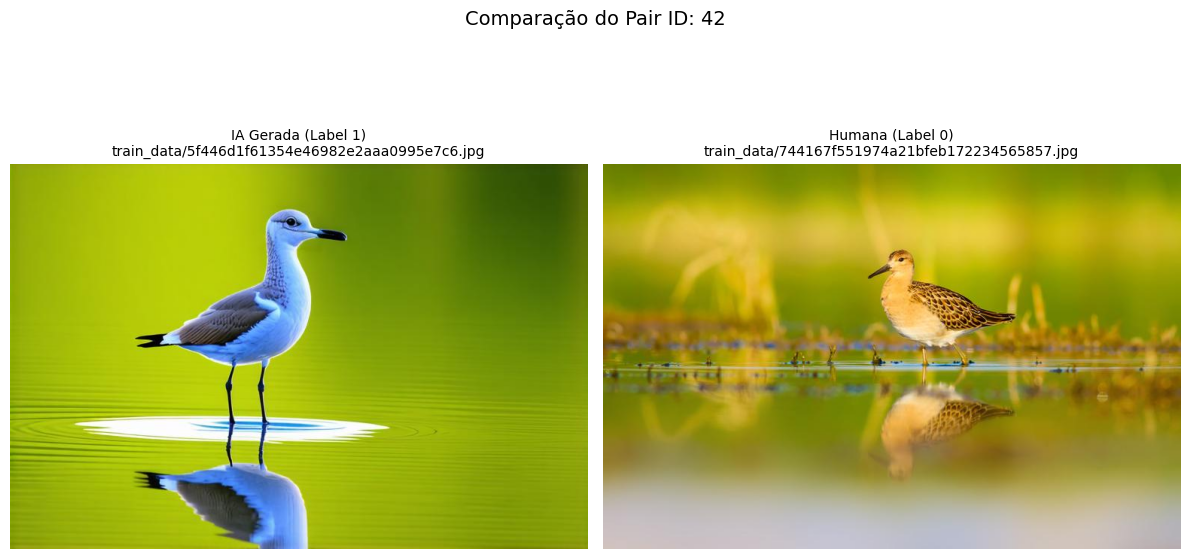

In [4]:
def plot_image_pair(df, pair_id):

    pair_df = df[df['pair_id'] == pair_id]
    
    if len(pair_df) != 2:
        print(f"Pair ID {pair_id} não encontrado ou incompleto")
        return
    
    # IA (label 1), Humana (label 0)
    ai_image_row = pair_df[pair_df['label'] == 1].iloc[0]
    human_image_row = pair_df[pair_df['label'] == 0].iloc[0]

    ai_img_path = main_dir + '/' + ai_image_row['file_name']
    human_img_path = main_dir + '/' + human_image_row['file_name']
    
    # Carregar imagens diretamente dos caminhos completos
    ai_img = plt.imread(ai_img_path)
    human_img = plt.imread(human_img_path)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'Comparação do Pair ID: {pair_id}', fontsize=14, y=1.05)
    
    axes[0].imshow(ai_img)
    axes[0].set_title(f'IA Gerada (Label 1)\n{ai_image_row["file_name"]}', fontsize=10)
    axes[0].axis('off')
    
    axes[1].imshow(human_img)
    axes[1].set_title(f'Humana (Label 0)\n{human_image_row["file_name"]}', fontsize=10)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


# Plotar um par genérico
plot_image_pair(train_df, pair_id=42)

### Avaliar a presença de rótulos e metadados relevantes

In [5]:
from collections import defaultdict

# Contar frequência de tags EXIF em uma amostra de imagens
exif_counts = defaultdict(int)
sample_size = 50  

for _, row in train_df.sample(sample_size).iterrows():
    try:
        with open(os.path.join(main_dir, row['file_name']), 'rb') as f:
            print (os.path.join(main_dir, row['file_name']))
            tags = exifread.process_file(f, details=False)
            for tag in tags:
                exif_counts[tag] += 1
    except:
        pass

print("Tags EXIF mais frequentes:")
for tag, count in sorted(exif_counts.items(), key=lambda x: -x[1]):
    print(f"{tag}: {count}/{sample_size}")

/kaggle/input/ai-vs-human-generated-dataset/train_data/f9a46129f70e485ab6eca1ad36104d71.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/97416ac451ff4d7b8a771debdae4b88c.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/cac2eb44fbef43d780bb1817f209415c.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/dd917214309c4e1aa6cc2e0779e17110.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/cfedc9084e0549aabfcc8cad6bbb1552.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/ac75056a509f4588a32dc372d3f9f328.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/7ccff6c3c5f846bcbe69806e46f713c5.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/74a06021e2e54daba330c5027c807cd8.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/52fec9e6647c4eb5acbd9e660e33e0b2.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/c6436ce101b34f65bcc700420e38e63b.jpg
/kaggle/input/ai-vs-human-generated-dataset/train_data/f65208d80a7c428bb87b7ec8c

## Todas as imagens são consistentes?

In [6]:
from PIL import Image

for _, row in train_df.sample(10).iterrows():
    try:
        img = Image.open(os.path.join(main_dir, row['file_name']))
        print(f"{row['file_name']}: OK ({img.size}, {img.mode})")
    except Exception as e:
        print(f"{row['file_name']}: ERRO - {str(e)}")

train_data/ad4cd537828643b2bfa2ec9cde489ec7.jpg: OK ((768, 368), RGB)
train_data/ddfe43d19cd7423ba7d1800ec9a8b311.jpg: OK ((768, 496), RGB)
train_data/9e29f308548a4573a6bac1a8435f7783.jpg: OK ((768, 512), RGB)
train_data/b491b358a7ed4095b007f764211d7497.jpg: OK ((752, 768), RGB)
train_data/19fa33d002ce4794b6a5260e3b4deeb0.jpg: OK ((768, 464), RGB)
train_data/d7b8a017d55242dea076e049b9ee05f3.jpg: OK ((768, 512), RGB)
train_data/23ff33b540a04dd1aa07218dd98b4805.jpg: OK ((768, 480), RGB)
train_data/5c7609051e6d41e49b772ded85327846.jpg: OK ((768, 496), RGB)
train_data/f0c086273e924e49ba405a33eec1a4da.jpg: OK ((768, 512), RGB)
train_data/43fe2ee6646c430ba26cb897a444965f.jpg: OK ((768, 512), RGB)


## Explorando pares

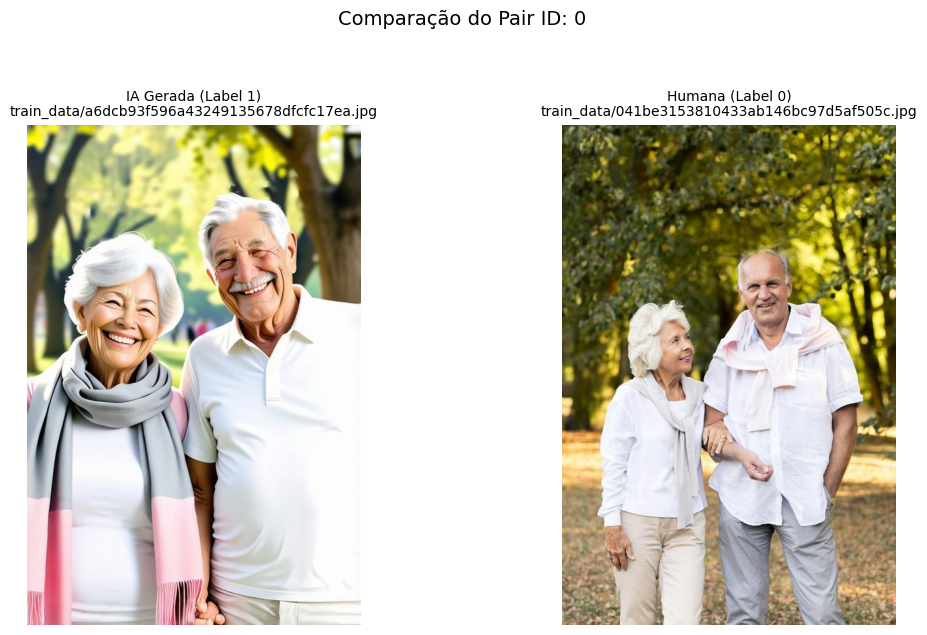

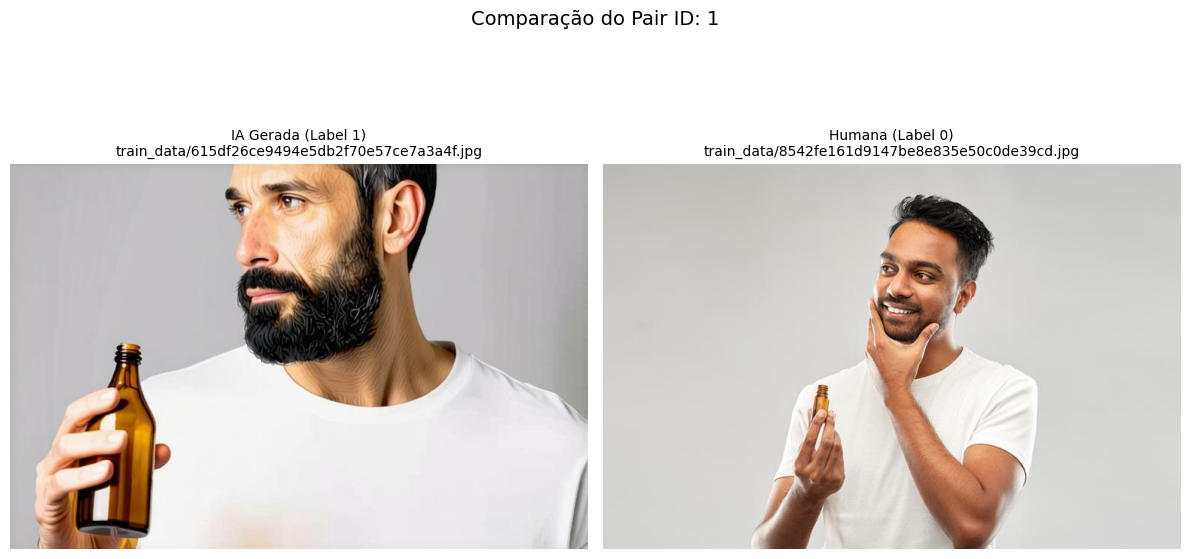

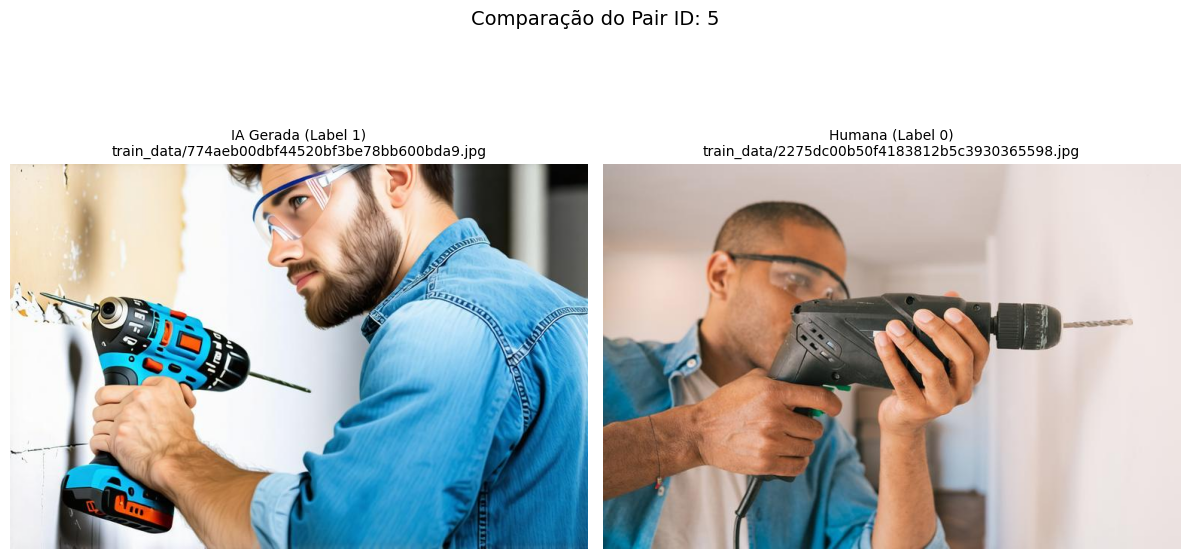

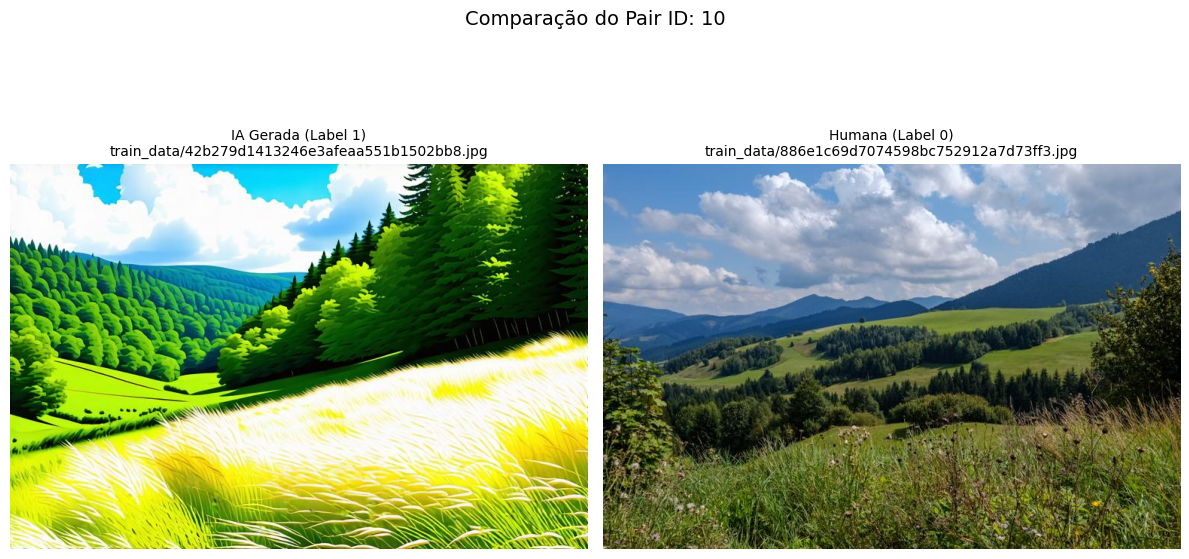

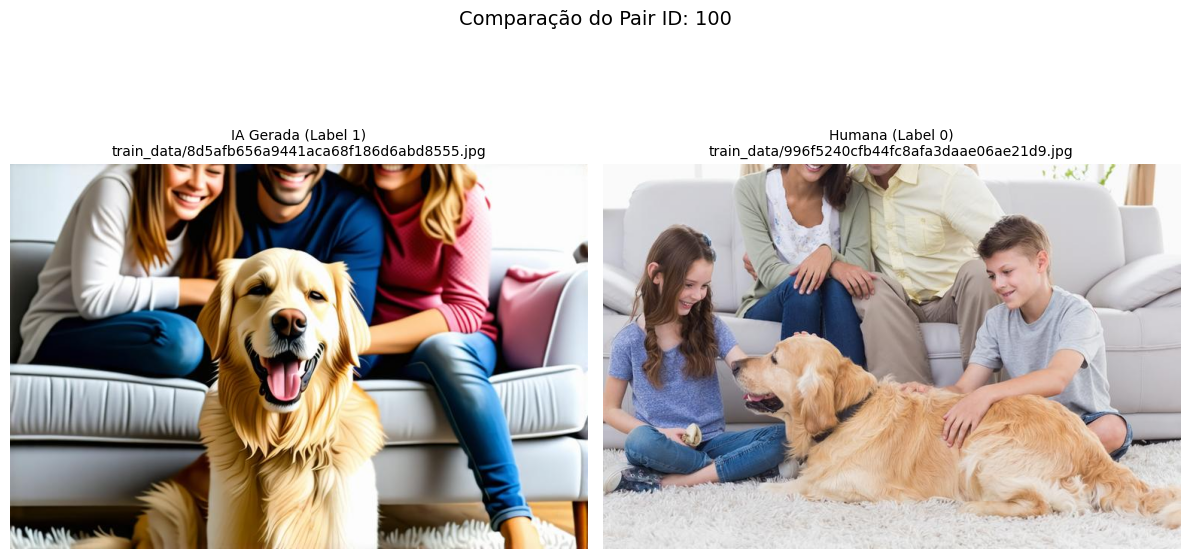

In [7]:
for pair_id in [0, 1, 5, 10, 100]:
    plot_image_pair(train_df, pair_id)

## Quais serão as features de imagem?

In [8]:
# Comparar métricas entre classes para uma amostra
sample_df = train_df.groupby('label').sample(10)

for _, row in sample_df.iterrows():
    img = cv2.imread(os.path.join(main_dir, row['file_name']))
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    print(f"Label {row['label']}: Variância do Laplaciano = {laplacian_var:.2f}")

Label 0: Variância do Laplaciano = 147.92
Label 0: Variância do Laplaciano = 815.05
Label 0: Variância do Laplaciano = 8.99
Label 0: Variância do Laplaciano = 1958.64
Label 0: Variância do Laplaciano = 341.89
Label 0: Variância do Laplaciano = 117.88
Label 0: Variância do Laplaciano = 218.14
Label 0: Variância do Laplaciano = 645.80
Label 0: Variância do Laplaciano = 540.40
Label 0: Variância do Laplaciano = 140.55
Label 1: Variância do Laplaciano = 1864.86
Label 1: Variância do Laplaciano = 1549.40
Label 1: Variância do Laplaciano = 789.47
Label 1: Variância do Laplaciano = 498.26
Label 1: Variância do Laplaciano = 536.05
Label 1: Variância do Laplaciano = 1703.35
Label 1: Variância do Laplaciano = 544.58
Label 1: Variância do Laplaciano = 466.13
Label 1: Variância do Laplaciano = 491.96
Label 1: Variância do Laplaciano = 495.96


In [9]:
for i in range(10):
    shape = plt.imread(f'{main_dir}/{train_df.file_name[i]}').shape
    print(f"Shape of the Image: {shape}")

Shape of the Image: (768, 512, 3)
Shape of the Image: (768, 512, 3)
Shape of the Image: (512, 768, 3)
Shape of the Image: (512, 768, 3)
Shape of the Image: (768, 512, 3)
Shape of the Image: (768, 512, 3)
Shape of the Image: (512, 768, 3)
Shape of the Image: (512, 768, 3)
Shape of the Image: (528, 768, 3)
Shape of the Image: (528, 768, 3)


## Engenharia de features
### Agora que entendemos melhor a distribuição de alguns dados, podemos começar a preparar as features que serão utilizadas pelo modelo

### Na análise de pares, foi observada a presença de texturas não-naturais e padrões repetitivos, então analisaremos: 
#### Contrast e Dissimilarity da Matriz de Co-ocorrência (GLCM), e FFT

In [10]:
from skimage.feature import graycomatrix, graycoprops

def calculate_glcm_features(image_gray):
    glcm = graycomatrix(image_gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    return {'glcm_contrast': contrast, 'glcm_dissimilarity': dissimilarity}

### Imagens geradas por IA tem a tendência de conter cores mais vívidas, e em alguns casos, mais saturadas, então utilizaremos o histograma do canal de saturação (HSV) e a assimetria do histograma RGB 

In [11]:
def calculate_color_stats(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    saturation = hsv[:,:,1].flatten()
    saturation_entropy = -np.sum(np.histogram(saturation, bins=20)[0] * np.log2(np.histogram(saturation, bins=20)[0] + 1e-6))
    
    red_channel = image[:,:,0].flatten()
    skewness_red = pd.Series(red_channel).skew()
    
    return {'saturation_entropy': saturation_entropy, 'skewness_red': skewness_red}

### Para modelar as anomalias em bordas e formas de objetos, utilizaremos a variância do laplaciano e a densidade de bordas Canny

In [12]:
def calculate_edge_features(image_gray):
    laplacian_var = cv2.Laplacian(image_gray, cv2.CV_64F).var()
    edges = cv2.Canny(image_gray, 100, 200)
    edge_density = np.mean(edges)  # proporção de pixels de borda
    
    return {'laplacian_var': laplacian_var, 'edge_density': edge_density}

### Técnicas de upsampling podem deixar artefatos, que são observados como padrões de frequência.
### Feature: Magnitude Média em Altas Frequências (FFT)

In [13]:
def calculate_fft_features(image_gray):
    fft = np.fft.fftshift(np.fft.fft2(image_gray))
    magnitude = np.log(np.abs(fft) + 1e-6)
    
    # foco em altas frequências (bordas do espectro)
    h, w = magnitude.shape
    crop_size = 50
    high_freq = magnitude[h//2 - crop_size:h//2 + crop_size, w//2 - crop_size:w//2 + crop_size]
    return {'fft_high_freq_mean': np.mean(high_freq)}

## Pipeline de extração
### Extraíremos todos os dados acima na função abaixo

In [14]:
def extract_all_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    features = {}
    features.update(calculate_glcm_features(gray))
    features.update(calculate_color_stats(image))
    features.update(calculate_edge_features(gray))
    features.update(calculate_fft_features(gray))
    
    return features

### Batch

In [15]:
from concurrent.futures import ThreadPoolExecutor

def batch_feature_extraction(paths, workers=4):
    with ThreadPoolExecutor(max_workers=workers) as executor:
        features = list(executor.map(extract_all_features, paths))
    return pd.DataFrame(features)

# Validação das features

Exemplos de caminhos completos:
 - /kaggle/input/ai-vs-human-generated-dataset/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg → Existe? True
 - /kaggle/input/ai-vs-human-generated-dataset/train_data/041be3153810433ab146bc97d5af505c.jpg → Existe? True
 - /kaggle/input/ai-vs-human-generated-dataset/train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg → Existe? True


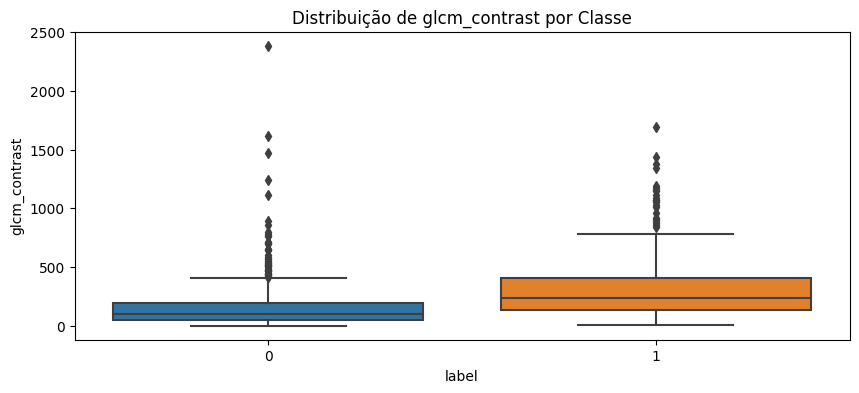

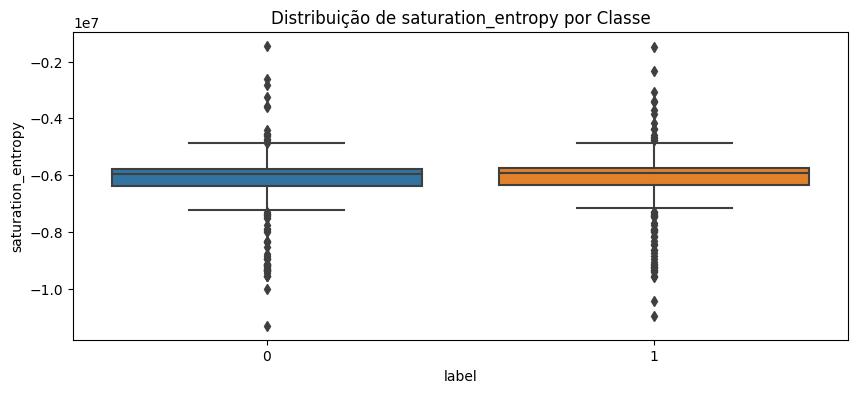

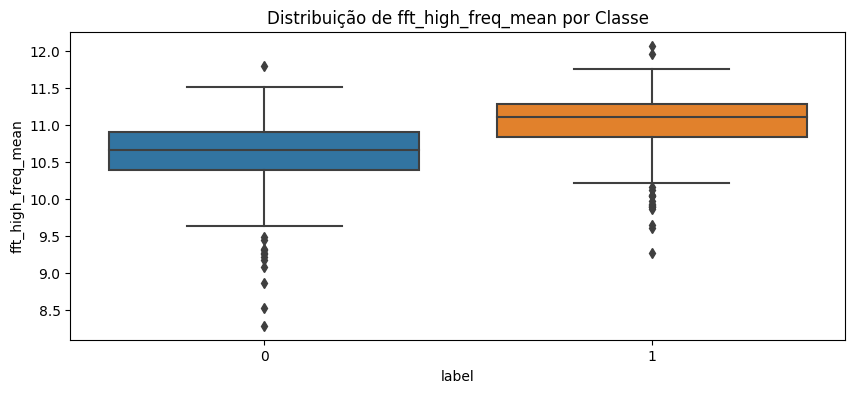

In [16]:
import seaborn as sns

path_list = train_df['file_name'].tolist()

full_paths = [
    os.path.join(main_dir, filename)
    for filename in path_list
]
path_list = train_df['file_name'].tolist()

full_paths = [
    os.path.join(main_dir, filename)
    for filename in path_list
]

print("Exemplos de caminhos completos:")
for path in full_paths[:3]:
    print(f" - {path} → Existe? {os.path.exists(path)}")


feature_df = batch_feature_extraction(full_paths)  # Amostra inicial

for feature in ['glcm_contrast', 'saturation_entropy', 'fft_high_freq_mean']:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=train_df['label'].iloc[:1000], y=feature_df[feature])
    plt.title(f'Distribuição de {feature} por Classe')
    plt.show()

## Encontramos duas features potencialmente úteis
#### Saturation entropy tem distribuições são bastante similares entre as classes, ambas têm medianas próximas a -0.6 × 10^7 e apresentam outliers tanto na parte superior quanto inferior, então não será utilizada

In [17]:
feature_df = feature_df.drop(columns=['saturation_entropy'])
feature_df.head()

glcm_contrast  glcm_dissimilarity  skewness_red  laplacian_var  \
0     186.540474            5.363263     -1.170233     524.291712   
1     114.089602            5.808576     -0.167379     301.777836   
2      76.595667            2.928035     -1.702754     193.888244   
3      44.797945            1.716937     -3.195632     164.509844   
4    1342.010384           18.582312     -1.279825    3050.940591   

   edge_density  fft_high_freq_mean  
0     12.569199           11.033311  
1     18.860283           11.044994  
2      9.334488           10.603737  
3      4.720421           10.298161  
4     34.007912           11.127374

## Vamos observar como a distribuição dos dados fica antes e depois de uma transformação log para cada feature

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


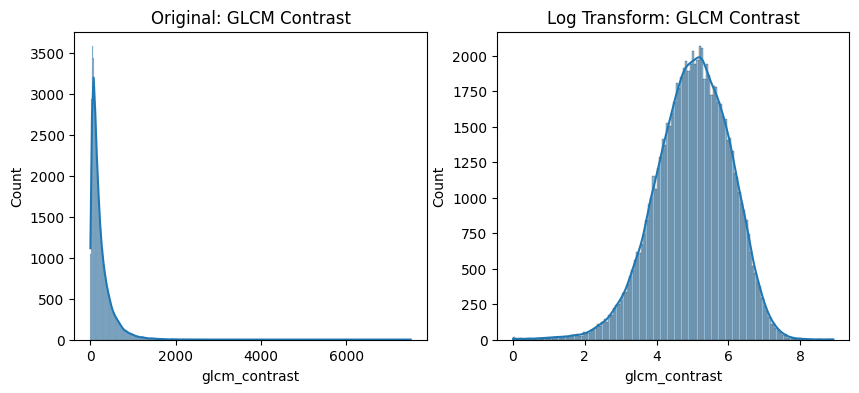

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


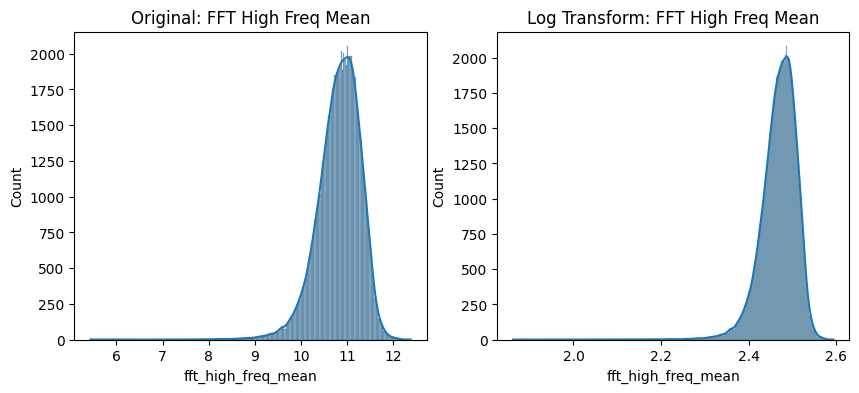

In [18]:
# plotar antes/depois das transformações
def plot_distribution(feature, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(feature, kde=True)
    plt.title(f'Original: {title}')
    plt.subplot(1, 2, 2)
    sns.histplot(np.log1p(feature), kde=True)
    plt.title(f'Log Transform: {title}')
    plt.show()

plot_distribution(feature_df['glcm_contrast'], 'GLCM Contrast')
plot_distribution(feature_df['fft_high_freq_mean'], 'FFT High Freq Mean')

In [19]:
from scipy.stats import skew

for col in feature_df.columns:
    s = skew(feature_df[col])
    print(f"{col}: Skewness = {s:.2f}")

glcm_contrast: Skewness = 3.86
glcm_dissimilarity: Skewness = 1.94
skewness_red: Skewness = -0.74
laplacian_var: Skewness = 4.58
edge_density: Skewness = 1.55
fft_high_freq_mean: Skewness = -1.10


# Criação de feature derivada e aplicação de log para GLCM Contrast, pois sua distribuição é muito assimétrica

In [20]:
feature_df['fft_glcm_ratio'] = feature_df['fft_high_freq_mean'] / (feature_df['glcm_contrast'] + 1e-6)
feature_df['log_glcm_contrast'] = np.log1p(feature_df['glcm_contrast'])

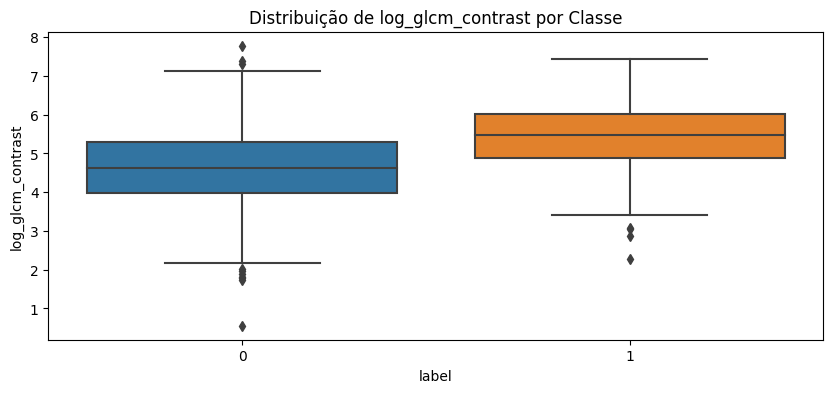

In [21]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=train_df['label'].iloc[:1000], y=feature_df['log_glcm_contrast'])
plt.title(f'Distribuição de log_glcm_contrast por Classe')
plt.show()

# Unificar o dataset de treino

In [22]:
full_train_df = pd.concat([train_df, feature_df], axis=1)
full_train_df.head()

file_name  label  pair_id  \
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1        0   
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0        0   
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1        1   
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0        1   
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1        2   

   glcm_contrast  glcm_dissimilarity  skewness_red  laplacian_var  \
0     186.540474            5.363263     -1.170233     524.291712   
1     114.089602            5.808576     -0.167379     301.777836   
2      76.595667            2.928035     -1.702754     193.888244   
3      44.797945            1.716937     -3.195632     164.509844   
4    1342.010384           18.582312     -1.279825    3050.940591   

   edge_density  fft_high_freq_mean  fft_glcm_ratio  log_glcm_contrast  
0     12.569199           11.033311        0.059147           5.233995  
1     18.860283           11.044994        0.096810           4.745711  
2      9.334488           10.603737        0.138438           4.351512  
3      4.720421           10.298161        0.229880           3.824239  
4     34.007912           11.127374        0.008292           7.202669

# Configurações

In [23]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
INIT_LR = 1e-4
FOLDS = 5

# **Modelagem híbrida**

In [24]:
from tensorflow.keras import applications
from sklearn.model_selection import GroupKFold

def build_hybrid_model(num_features):

    # Branch de Imagens
    image_input = layers.Input(shape=(*IMG_SIZE, 3), name='image_input')
    
    # Data Augmentation integrado
    x = layers.RandomFlip("horizontal")(image_input)
    x = layers.RandomRotation(0.1)(x)
    
    # Base pré-treinada
    base_model = applications.EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_tensor=x
    )
    base_model.trainable = False 
    
    # pooling
    image_features = layers.GlobalAveragePooling2D(name='image_pool')(base_model.output)

    # Branch de Features Manuais
    feature_input = layers.Input(shape=(num_features,), name='feature_input')
    f = layers.Dense(64, activation='relu')(feature_input)
    f = layers.BatchNormalization()(f)
    
    # Combina as representações das imagens e features manuais em um único vetor
    combined = layers.concatenate([image_features, f])
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)
    
    output = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model(
        inputs=[image_input, feature_input],
        outputs=output,
        name='Hybrid_AI_Detector'
    )

# Validação cruzada estratificada por pair_id

In [25]:
full_train_df["full_path"] = full_train_df["file_name"].apply(
    lambda x: os.path.join(main_dir, x)
)

# Verificar caminhos
print(full_train_df[["file_name", "full_path"]].head())
print("\nExemplo de caminho válido?", os.path.exists(full_train_df["full_path"].iloc[0]))

                                         file_name  \
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg   
1  train_data/041be3153810433ab146bc97d5af505c.jpg   
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg   
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg   
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg   

                                           full_path  
0  /kaggle/input/ai-vs-human-generated-dataset/tr...  
1  /kaggle/input/ai-vs-human-generated-dataset/tr...  
2  /kaggle/input/ai-vs-human-generated-dataset/tr...  
3  /kaggle/input/ai-vs-human-generated-dataset/tr...  
4  /kaggle/input/ai-vs-human-generated-dataset/tr...  

Exemplo de caminho válido? True


In [26]:
# Garantir que pares não sejam divididos entre folds
gkf = GroupKFold(n_splits=FOLDS)

# Features manuais + caminhos das imagens
features = feature_df.values  # DataFrame com suas features processadas
image_paths = full_train_df['full_path'].values
labels = full_train_df['label'].values
groups = full_train_df['pair_id'].values  # Para GroupKFold

# Conectando os datasets

In [27]:
def create_hybrid_dataset(df, feature_columns, batch_size=32):
    # dados brutos
    image_paths = df["full_path"].values
    manual_features = df[feature_columns].values.astype(np.float32)
    labels = df["label"].values.astype(np.float32)
    
    # carregar e pré-processar uma imagem
    def load_and_preprocess(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        return img
    
    # imagens
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths).map(load_and_preprocess)
    
    # features manuais
    feature_ds = tf.data.Dataset.from_tensor_slices(manual_features)
    
    # labels
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    
    # combinar todos os componentes
    combined_ds = tf.data.Dataset.zip(
        ((image_ds, feature_ds), label_ds)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return combined_ds

# Config da cross eval

In [28]:
# Definir colunas de features manuais
FEATURE_COLS = ["glcm_contrast", "glcm_dissimilarity", "laplacian_var", "edge_density", "fft_high_freq_mean"]

# Configurar KFold estratificado por pair_id
gkf = GroupKFold(n_splits=5)
fold = 0

for train_idx, val_idx in gkf.split(
    full_train_df, 
    groups=full_train_df["pair_id"]
):
    fold += 1
    print(f"\n=== Fold {fold}/5 ===")
    
    # Dividir dados
    train_df = full_train_df.iloc[train_idx]
    val_df = full_train_df.iloc[val_idx]
    
    # Criar datasets
    train_ds = create_hybrid_dataset(train_df, FEATURE_COLS)
    val_ds = create_hybrid_dataset(val_df, FEATURE_COLS)
    
    # Construir e treinar modelo (mesma arquitetura)
    model = build_hybrid_model(num_features=len(FEATURE_COLS))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
        ]
    )


=== Fold 1/5 ===
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 167s 76ms/step - auc: 0.9056 - loss: 0.3732 - precision: 0.8227 - recall: 0.8400 - val_auc: 0.9773 - val_loss: 0.2151 - val_precision: 0.8924 - val_recall: 0.9540 - learning_rate: 1.0000e-04
Epoch 2/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 114s 57ms/step - auc: 0.9770 - loss: 0.1952 - precision: 0.9221 - recall: 0.9248 - val_auc: 0.9825 - val_loss: 0.1959 - val_precision: 0.8956 - val_recall: 0.9665 - learning_rate: 1.0000e-04
Epoch 3/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 113s 56ms/step - auc: 0.9833 - loss: 0.1660 - precision: 0.9343 - recall: 0.9347 - val_auc: 0.9849 - val_loss: 0.1830 - val_precision: 0.9044 - val_recall: 0.9682 - learning_rate: 1.0000e-04
Epoch 4/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 113s 57ms/step - auc: 0.9864 - loss: 0.1492 - precision: 0.9401 - recall: 0.9437 - val_auc: 0.9859 - val_loss: 0.1729 - val_precision: 0.9053 - val_recall: 0.9711 - learning_rate: 1.0000e-04

# Avaliando o último fold

In [29]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# o modelo precisa estar carregado na memória
test_ds = create_hybrid_dataset(full_train_df, FEATURE_COLS)

# gerar predições
y_probs = model.predict(test_ds).flatten()
y_pred = (y_probs > 0.5).astype(int) # valor não-optimal
y_true = full_train_df['label'].values

# métricas
print(f"AUC: {roc_auc_score(y_true, y_probs):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")

2499/2499 ━━━━━━━━━━━━━━━━━━━━ 103s 40ms/step
AUC: 0.9955
Precision: 0.9516
Recall: 0.9812


In [30]:
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

print(f"""
=== Métricas do Modelo ===
- AUC: {roc_auc_score(y_true, y_probs):.4f}
- Precision: {precision_score(y_true, y_pred):.4f}
- Recall: {recall_score(y_true, y_pred):.4f}
- F1-Score: {f1_score(y_true, y_pred):.4f}
""")


=== Métricas do Modelo ===
- AUC: 0.9955
- Precision: 0.9516
- Recall: 0.9812
- F1-Score: 0.9662



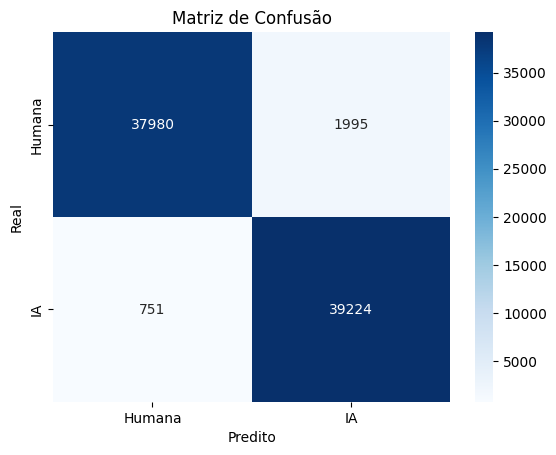

In [31]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Humana', 'IA'], yticklabels=['Humana', 'IA'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

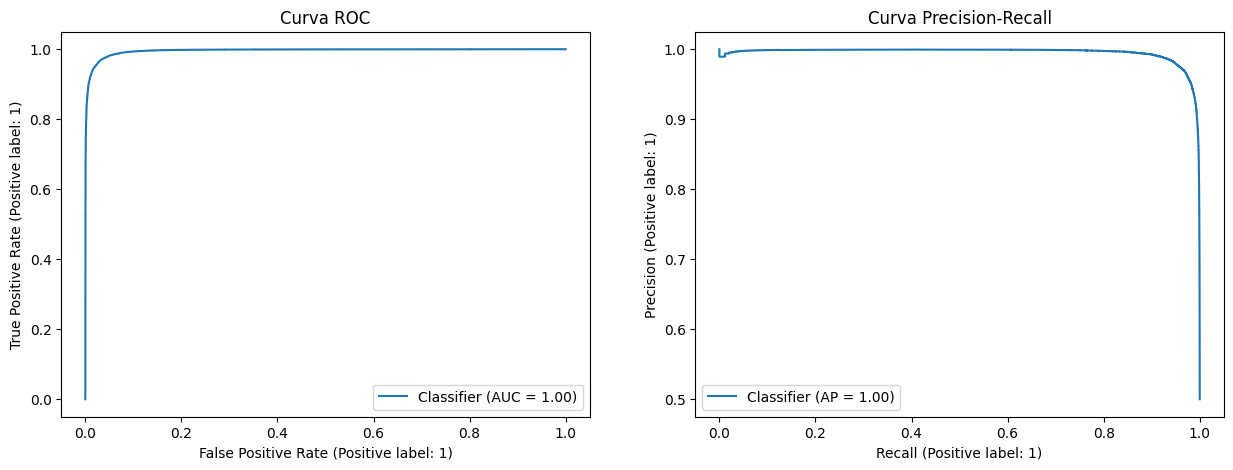

In [32]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Curva ROC
RocCurveDisplay.from_predictions(y_true, y_probs, ax=ax1)
ax1.set_title("Curva ROC")

# Curva Precision-Recall
PrecisionRecallDisplay.from_predictions(y_true, y_probs, ax=ax2)
ax2.set_title("Curva Precision-Recall")

plt.show()

In [33]:
# DF com metadados e predições
error_df = full_train_df.copy()
error_df['pred_prob'] = y_probs
error_df['pred_label'] = y_pred

# Falsos negativos (IAs classificadas como humanas)
false_negatives = error_df[(error_df['label'] == 1) & (error_df['pred_label'] == 0)]
print("Falsos Negativos (Top 5):")
print(false_negatives[['file_name', 'pred_prob']].head())

# Falsos positivos (Humanas classificadas como IA)
false_positives = error_df[(error_df['label'] == 0) & (error_df['pred_label'] == 1)]
print("\nFalsos Positivos (Top 5):")
print(false_positives[['file_name', 'pred_prob']].head())

Falsos Negativos (Top 5):
                                           file_name  pred_prob
214  train_data/0d8de498978d4cc1918f1f246112dbd8.jpg   0.256807
332  train_data/67d1b9f1f71242249629c5a73814c343.jpg   0.289110
506  train_data/b84391c701ca4007b03df9637b42dd27.jpg   0.464079
592  train_data/4997a597c32246c68ffa5ca73700e405.jpg   0.309625
612  train_data/f4492329f9644bc790e87db27e934e58.jpg   0.435611

Falsos Positivos (Top 5):
                                           file_name  pred_prob
13   train_data/33a6a93ef8074ef684291557a00a408b.jpg   0.777917
31   train_data/f4619b8c76e643ae94bcab199dd8aa40.jpg   0.924277
67   train_data/48e8b84930cc4203b79633b21d96391e.jpg   0.738224
89   train_data/862cfe50421946e1940287457c410010.jpg   0.947812
113  train_data/d2783fee800b4db7a069cd9bc097b7e3.jpg   0.951388


In [34]:
from sklearn.metrics import precision_recall_curve

# threshold ótimo para F1-Score
precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Threshold Ideal: {best_threshold:.4f}")
print(f"F1-Score no Threshold Ideal: {np.max(f1_scores):.4f}")

# aplicar novo threshold
y_pred_optimized = (y_probs > best_threshold).astype(int)
print("\n=== Métricas com Threshold Otimizado ===")
print(f"Precision: {precision_score(y_true, y_pred_optimized):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_optimized):.4f}")

Threshold Ideal: 0.6467
F1-Score no Threshold Ideal: 0.9686

=== Métricas com Threshold Otimizado ===
Precision: 0.9678
Recall: 0.9695


In [35]:
model.save('/kaggle/working/final_model.keras')  
print("Arquivos após salvamento manual:", os.listdir('/kaggle/working/'))

Arquivos após salvamento manual: ['final_model.keras', '__notebook__.ipynb']


# Passar os dados pelo modelo e criar o **submission.csv**

In [36]:
# Definir colunas de features manuais (novamente para não ter que treinar o modelo de novo)
FEATURE_COLS = ["glcm_contrast", "glcm_dissimilarity", "laplacian_var", "edge_density", "fft_high_freq_mean"]

# carregar o modelo
model = build_hybrid_model(num_features=len(FEATURE_COLS))
model.load_weights('/kaggle/working/final_model.keras')

In [37]:
TEST_CSV_PATH = '/kaggle/input/ai-vs-human-generated-dataset/test.csv'
TEST_DATA_PATH = '/kaggle/input/ai-vs-human-generated-dataset'

test_2_predict = pd.read_csv(TEST_CSV_PATH)
test_2_predict.head

<bound method NDFrame.head of                                                      id
0     test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1     test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2     test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3     test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4     test_data_v2/a16495c578b7494683805484ca27cf9f.jpg
...                                                 ...
5535  test_data_v2/483412064ff74d9d9472d606b65976d9.jpg
5536  test_data_v2/c0b49ba4081a4197b422dac7c15aea7f.jpg
5537  test_data_v2/01454aaedec140c0a3ca1f48028c41cf.jpg
5538  test_data_v2/e9adfea8b67e4791968c4c2bdd8ec343.jpg
5539  test_data_v2/ba8f4198e8d74d3394fa56c56af23442.jpg

[5540 rows x 1 columns]>

In [38]:
test_2_predict['full_path'] = test_2_predict['id'].apply(
    lambda x: os.path.join(TEST_DATA_PATH, x)  
)


In [39]:
test_path_list = test_2_predict['full_path'].tolist()

feature_df = batch_feature_extraction(test_path_list) 

In [40]:
#Normalizações
feature_df['fft_glcm_ratio'] = feature_df['fft_high_freq_mean'] / (feature_df['glcm_contrast'] + 1e-6)
feature_df['log_glcm_contrast'] = np.log1p(feature_df['glcm_contrast'])
feature_df.drop(columns=['saturation_entropy'], inplace=True)
feature_df.head()

glcm_contrast  glcm_dissimilarity  skewness_red  laplacian_var  \
0     144.048051            4.019898      0.011096     735.342255   
1     305.431657            9.524895      0.546308    1515.025804   
2      12.295171            1.482370     -1.125579      70.007604   
3     279.105479           11.484310     -0.162949    1869.978242   
4      37.170148            2.542038     -1.251125     170.230859   

   edge_density  fft_high_freq_mean  fft_glcm_ratio  log_glcm_contrast  
0     10.160675           10.815344        0.075082           4.977065  
1     30.541934           12.052176        0.039459           5.724995  
2      3.592939           10.895373        0.886151           2.587401  
3     61.187001           11.588031        0.041518           5.635166  
4      5.105735           10.802112        0.290613           3.642054

In [41]:
assert len(test_2_predict) == len(feature_df), "DataFrames têm tamanhos diferentes!"
test_2_predict.index
feature_df.head()

glcm_contrast  glcm_dissimilarity  skewness_red  laplacian_var  \
0     144.048051            4.019898      0.011096     735.342255   
1     305.431657            9.524895      0.546308    1515.025804   
2      12.295171            1.482370     -1.125579      70.007604   
3     279.105479           11.484310     -0.162949    1869.978242   
4      37.170148            2.542038     -1.251125     170.230859   

   edge_density  fft_high_freq_mean  fft_glcm_ratio  log_glcm_contrast  
0     10.160675           10.815344        0.075082           4.977065  
1     30.541934           12.052176        0.039459           5.724995  
2      3.592939           10.895373        0.886151           2.587401  
3     61.187001           11.588031        0.041518           5.635166  
4      5.105735           10.802112        0.290613           3.642054

In [42]:
full_pred_df = test_2_predict.join(feature_df, how="inner")
full_pred_df.head()

id  \
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg   
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg   
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg   
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg   
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg   

                                           full_path  glcm_contrast  \
0  /kaggle/input/ai-vs-human-generated-dataset/te...     144.048051   
1  /kaggle/input/ai-vs-human-generated-dataset/te...     305.431657   
2  /kaggle/input/ai-vs-human-generated-dataset/te...      12.295171   
3  /kaggle/input/ai-vs-human-generated-dataset/te...     279.105479   
4  /kaggle/input/ai-vs-human-generated-dataset/te...      37.170148   

   glcm_dissimilarity  skewness_red  laplacian_var  edge_density  \
0            4.019898      0.011096     735.342255     10.160675   
1            9.524895      0.546308    1515.025804     30.541934   
2            1.482370     -1.125579      70.007604      3.592939   
3           11.484310     -0.162949    1869.978242     61.187001   
4            2.542038     -1.251125     170.230859      5.105735   

   fft_high_freq_mean  fft_glcm_ratio  log_glcm_contrast  
0           10.815344        0.075082           4.977065  
1           12.052176        0.039459           5.724995  
2           10.895373        0.886151           2.587401  
3           11.588031        0.041518           5.635166  
4           10.802112        0.290613           3.642054

In [43]:
def predict_with_hybrid_model(model, df, feature_columns, batch_size=32):
    """
    Realiza predição com o modelo híbrido passando os inputs como uma lista
    na ordem correta definida no modelo.
    """
    # Listas com dados brutos
    image_paths = df["full_path"].values
    manual_features = df[feature_columns].values.astype(np.float32)
    
    # Função para carregar e pré-processar uma imagem
    def load_and_preprocess(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        return img.numpy()
    
    # Carregar todas as imagens
    print("Carregando imagens...")
    images = []
    for path in image_paths:
        img = load_and_preprocess(path)
        images.append(img)
    
    # Converter para arrays numpy
    images_array = np.stack(images)
    features_array = manual_features
    
    print(f"Images array shape: {images_array.shape}")
    print(f"Features array shape: {features_array.shape}")
    
    # Realizar predição passando uma LISTA com os inputs na mesma ordem que o modelo foi definido
    print("Realizando predição...")
    predictions = model.predict(
        [images_array, features_array],  # Lista em vez de dicionário
        batch_size=batch_size
    )
    
    return predictions

In [44]:
result_from_function = predict_with_hybrid_model(model, full_pred_df, FEATURE_COLS, batch_size=32)

Carregando imagens...
Images array shape: (5540, 224, 224, 3)
Features array shape: (5540, 5)
Realizando predição...
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step


In [45]:
result_from_function

array([[0.36910903],
       [0.7208276 ],
       [0.0198682 ],
       ...,
       [0.00107044],
       [0.05208365],
       [0.40031186]], dtype=float32)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


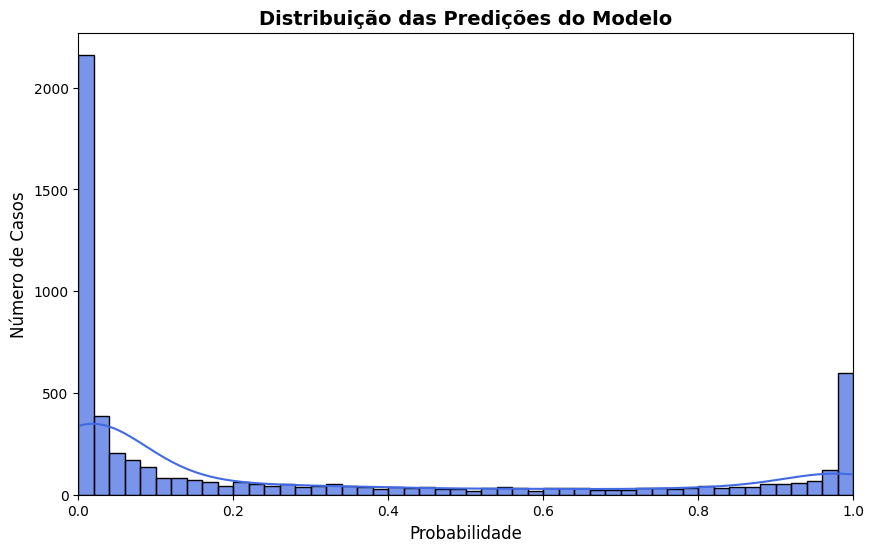

In [46]:
# plotando a distribuição das probabilidades obtidas pelo modelo

import seaborn as sns

data = pd.Series(result_from_function.flatten())

plt.figure(figsize=(10, 6))

# histograma e KDE 
sns.histplot(data, bins=50, kde=True, color='royalblue', edgecolor='black', alpha=0.7)

plt.title('Distribuição das Predições do Modelo', fontsize=14, fontweight='bold')
plt.xlabel('Probabilidade', fontsize=12)
plt.ylabel('Número de Casos', fontsize=12)
plt.xlim(0, 1)  # range de 0 a 1
plt.show()

In [47]:
binary_predictions = (result_from_function > 0.3).astype(int) # treshold ideal era 0.6415, mas o 0.5 pontuou melhor
binary_predictions

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [48]:
np.sum(binary_predictions == 1)

1896

In [49]:
def convert_to_submission(df, column_name, predictions):

    # Converte uma coluna de um DataFrame e um array de previsões em um df no formato de submissão.

    submission_df = pd.DataFrame({
        "id": df[column_name].values,  # Pegando os nomes dos arquivos
        "label": predictions.flatten().astype(int)  # Convertendo previsões para inteiros
    })
    
    return submission_df



submission = convert_to_submission(full_pred_df, "id", binary_predictions)
print(submission)


                                                     id  label
0     test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg      1
1     test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg      1
2     test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg      0
3     test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg      0
4     test_data_v2/a16495c578b7494683805484ca27cf9f.jpg      0
...                                                 ...    ...
5535  test_data_v2/483412064ff74d9d9472d606b65976d9.jpg      0
5536  test_data_v2/c0b49ba4081a4197b422dac7c15aea7f.jpg      0
5537  test_data_v2/01454aaedec140c0a3ca1f48028c41cf.jpg      0
5538  test_data_v2/e9adfea8b67e4791968c4c2bdd8ec343.jpg      0
5539  test_data_v2/ba8f4198e8d74d3394fa56c56af23442.jpg      1

[5540 rows x 2 columns]


In [50]:
submission.to_csv('submission.csv', index=False)

In [51]:
!ls -la

total 97552
drwxr-xr-x 2 root root     4096 Feb 26 09:54 .
drwxr-xr-x 7 root root     4096 Feb 26 05:49 ..
-rw-r--r-- 1 root root 26695777 Feb 26 09:44 final_model.keras
---------- 1 root root 72895542 Feb 26 09:55 __notebook__.ipynb
-rw-r--r-- 1 root root   288089 Feb 26 09:54 submission.csv


In [52]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='submission.csv')

# from https://www.kaggle.com/code/arkaung/download-csv-file